In [11]:
from wrangler import *
import matplotlib.pyplot as plt
import matplotlib as mpl 
from PIL import Image, ImageOps
from matplotlib.animation import FuncAnimation, writers
import seaborn as sns
import numpy as np
import pandas as pd
from sktrajectory import *
from pytrajectory import *
from trajectory import *
import torch
from LSTM import LSTM

In [2]:
pdf = Wrangler.load_pickle('data/pdf_69.pkl')

In [3]:
l_df = pd.read_csv('bsc-3m/signals_dense.csv')
l_xy = Wrangler.load_pickle('bsc-3m/signal_lines_true.pickle')

In [4]:
model = LSTM(33, 100, 1, 2, 0.2, 849)
model.load_state_dict(torch.load('models/lstm_sex.pt'))
model.eval()

LSTM(
  (lstm): LSTM(33, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [5]:
class T(Trajectory):
    def __init__(self, data, l_df, l_xy, clf):
        super(T, self).__init__(data, l_df, l_xy)
        self.clf = clf
        
    def predict(self):
        with torch.no_grad():
            cols = ['x', 'y', 'd_t-1', 'd_t-2', 'd_t-3', 'd_light', 'l0', 'l1',
            'l2', 'l3', 'dir_0', 'dir_1', 'dir_2'] + ['d_z_'+str(i) for i in range(20)]
            x = self.sim_data[cols].to_numpy()
            xx = torch.from_numpy(x).reshape(1, -1, len(cols)).float()
            lens = torch.tensor([xx.size(1)])
            out = self.clf(xx, lens)
            return float(out[-1, lens[0]-1, 0])
        

In [7]:
mpl.rcParams['animation.ffmpeg_path'] = r'D:\ffmpeg\bin\ffmpeg.exe'

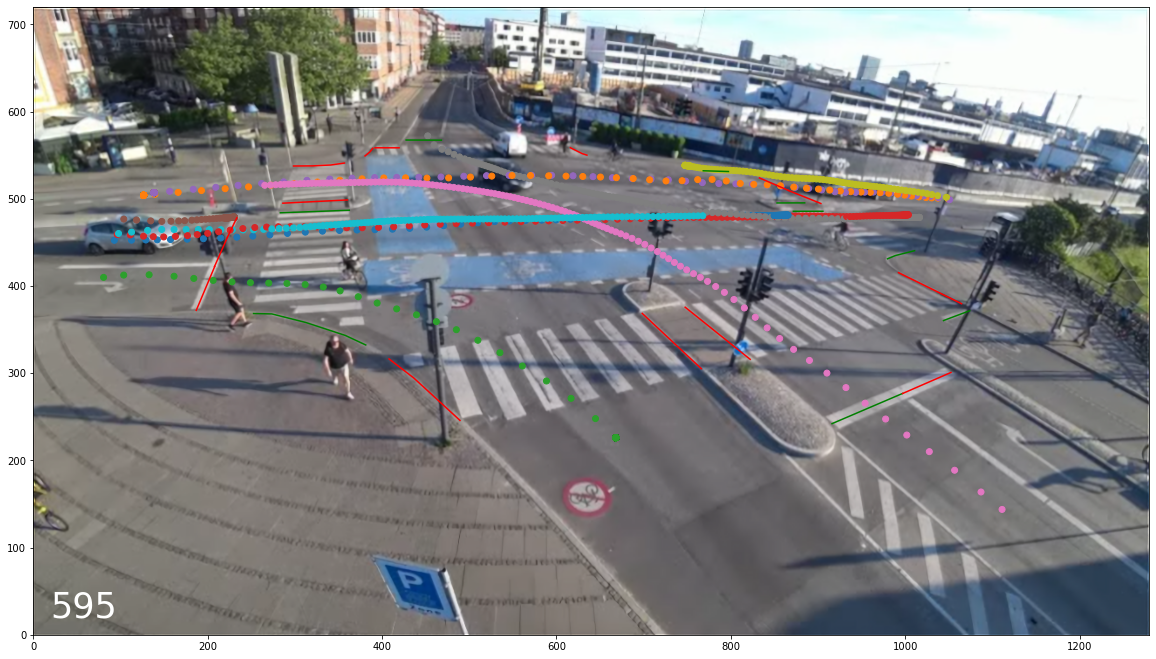

In [23]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
img = Image.open("intersection2.png")
img = ImageOps.flip(img)

im = ax.imshow(img, origin='lower')
ln = [ax.plot([],[])[0] for _ in range(l_df.shape[-1]-1)]  # traffic lines
txt = ax.text(20,20, '', fontsize=35, color='w')  # frame number
sc = ax.scatter([], []) #  , s=200)  # cars
# zones = [ax.plot([], [])[0] for _ in range(20)]
patches = ln + [sc] + [txt]  #  + zones

traj_count = 10
Trajectory.index_gen = itertools.count()
t = [T(pdf.iloc[i], l_df, l_xy, model) for i in range(traj_count)]
t[0].reset_full_sim_data()
for i in range(traj_count):
    t[i].init_sim(0)
for i in range(traj_count):
    t[i].get_d_zones(0)

def init():
    for i in range(len(ln)):
        ln[i].set_data(l_xy[i]['x'], l_xy[i]['y'])
    
    return patches

def update(frame):
    row = l_df.loc[frame]
    for i in range(l_df.shape[1]-1):
        ln[i].set_color(['red', 'orange', 'yellow', 'green'][row[str(i)]])
    
    txt.set(text=str(frame))
    
    
    for i in range(traj_count):
        try:
            t[i].step(frame)
        except IndexError:
            continue
    for i in range(traj_count):
        try:
            t[i].get_d_zones(frame)
        except IndexError:
            continue
    
    xy = t[0].full_sim_data[['x', 'y']]
    sc.set_offsets(xy)
    sc.set(color=[sns.color_palette()[i] for i in t[0].full_sim_data['index']])
    
#     for i in range(20):
#         x, y = t.sim_data[t.sim_data['frame']==frame]['z_'+str(i)].iloc[0].exterior.xy
#         zones[i].set_data(x, y)
    
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(5,600,5),    # np.arange(0, 12000, 10), # interval=30,
                    init_func=init)#, blit=True)

Writer = writers['ffmpeg']
writer = Writer(fps=6) # , bitrate=1800)
ani.save('movies/test.mp4', writer)

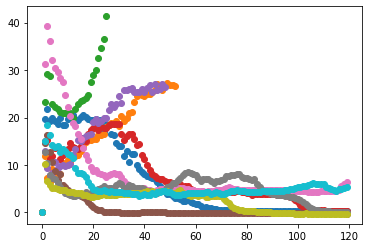

In [29]:
fig, ax = plt.subplots()
for i in range(traj_count):
    ax.scatter(np.arange(len(t[i].sim_data['d_t-1'])), t[i].sim_data['d_t-1'])

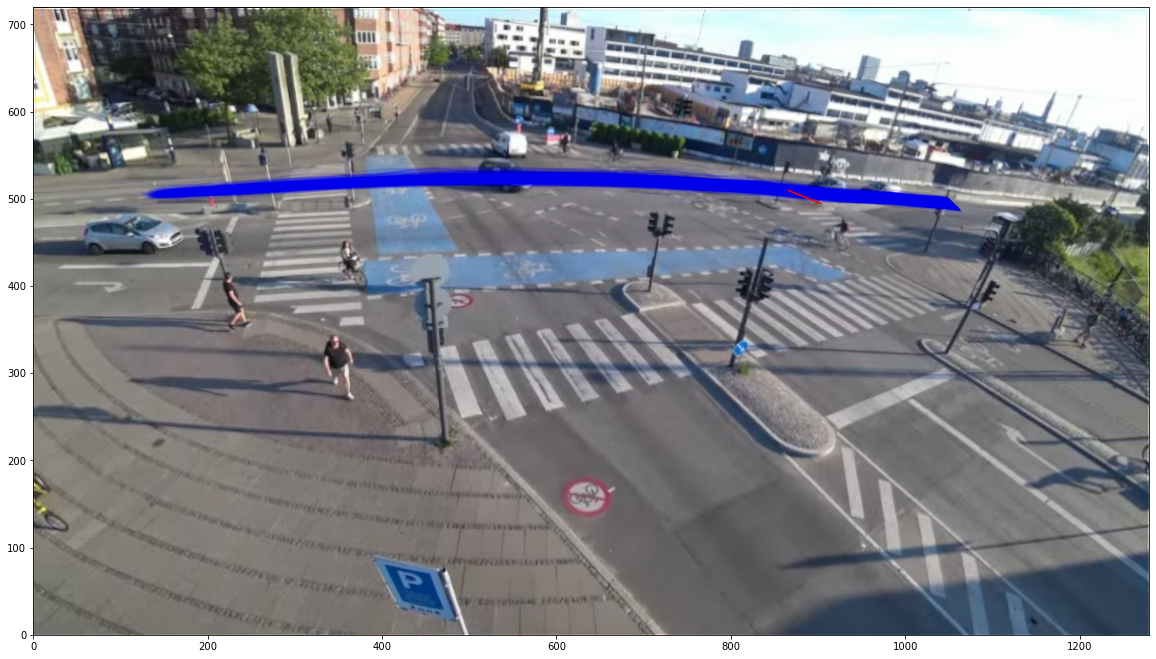

In [68]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
img = Image.open("intersection2.png")
img = ImageOps.flip(img)
im = ax.imshow(img, origin='lower')

mask = pdf['cluster'] == 11
for _, row in pdf.loc[mask].iterrows():
    ax.plot(row['x'], row['y'], c='b', alpha=0.05)
l = 5
ax.plot(l_xy[l]['x'], l_xy[l]['y'], c='r')

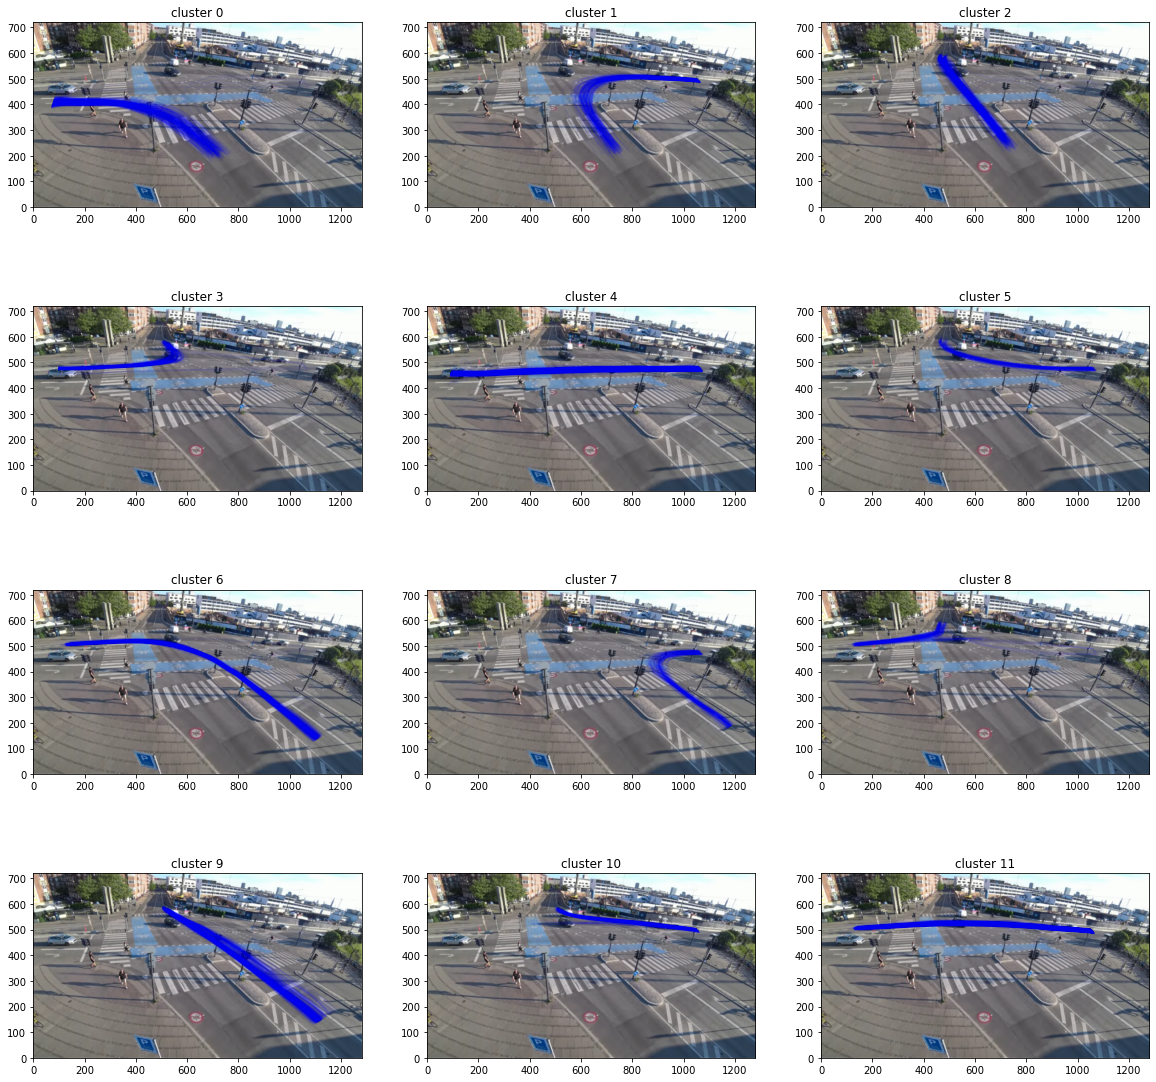

In [46]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
img = Image.open("intersection2.png")
img = ImageOps.flip(img)

for r in range(4):
    for c in range(3):
        cluster = r*3+c
        ax[r, c].set_title(f'cluster {cluster}')
        ax[r, c].set_xlim(0, 1280)
        ax[r, c].set_ylim(0, 720)
        im = ax[r, c].imshow(img, origin='lower')
        mask = pdf['cluster'] == cluster
        for _, row in pdf.loc[mask].iterrows():
            ax[r, c].plot(row['x'], row['y'], c='b', alpha=0.05)

In [85]:
for c in np.unique(pdf['cluster']):
    mask = pdf['cluster'] == c
    lens = np.array([len(row['x']) for _, row in pdf.loc[mask].iterrows()])
    cut = np.percentile(lens, 95)
    remove = lens > cut
    idx = pdf.loc[mask].loc[remove].index
    break

In [38]:
np.unique(pdf['cluster'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)